# Fiber photometry demo

This tutorial demonstrates how to access an NWB file from the [DANDI:001265](https://dandiarchive.org/dandiset/001265/draft) dataset using `pynwb`.

This dataset contains fiber photometry recordings during decision-making behavioral task in rats. Deeplabcut software (v.2.2.3) was used for tracking the behavior ports (right port, central port, and left port) and 6 body parts (right ear, nose, left ear, mid-point along the right torso, mid-point along the left torso, and base of the tail). Video data were acquired using cameras attached to the ceiling of behavior rigs to capture the top-down view of the arena (Doric USB3 behavior camera, Sony IMX290, recorded with Doric Neuroscience Studio v6 software). The fluorescence from activity-dependent (GRAB-DA and GRAB-ACh) and activity-independent (isosbestic or mCherry) signals was acquired simultaneously via demodulation and downsampled on-the-fly by a factor of 25 to ~481.9 Hz. The behavioral tasks were conducted in a high-throughput facility where rats were trained in increasingly complex protocols. Trials were initiated by a nose-poke in a lit center port and required maintaining a center fixation for 0.8 to 1.2 seconds, during which a tone indicated the possible reward size. A subsequent side LED indicated the potential reward location, followed by a delay period drawn from an exponential distribution (mean = 2.5 s). Rats could opt out at any time by poking the unlit port, restarting the trial. Catch trials, where the delay period only ended if the rat opted out, constituted 15-25% of the trials. Rats received penalties for premature fixation breaks. Additionally, the tasks introduced semi-observable hidden states by varying reward statistics across uncued blocks (high, low, and mixed), structured hierarchically, with blocks transitioning after 40 successfully completed trials.

# Reading an NWB file

This section demonstrates how to read an NWB file using `pynwb`.
Based on the [NWB File Basics](https://pynwb.readthedocs.io/en/stable/tutorials/general/plot_file.html#sphx-glr-tutorials-general-plot-file-py) tutorial from [PyNWB](https://pynwb.readthedocs.io/en/stable/#).

An [NWBFile](https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.NWBFile) represents a single session of an experiment. Each NWBFile must have a `session description`, `identifier`, and `session start time`.

Reading is carried out using the [NWBHDF5IO](https://pynwb.readthedocs.io/en/stable/pynwb.html#pynwb.NWBHDF5IO) class. To read the NWB file use the read mode "r" to retrieve an NWBFile object.

In [2]:
from pynwb import NWBHDF5IO
import ndx_structured_behavior

nwbfile_path = "/Users/weian/data/001265/sub-G026/sub-G026_ses-RWTautowait2-20210528-101504.nwb"
io = NWBHDF5IO(nwbfile_path, load_namespaces=True)
nwbfile = io.read()

# Streaming an NWB file

This section demonstrates how to access the files on the [DANDI Archive](https://dandiarchive.org) without downloading them. Based on the [Streaming NWB files](https://pynwb.readthedocs.io/en/stable/tutorials/advanced_io/streaming.html) tutorial from [PyNWB](https://pynwb.readthedocs.io/en/stable/#).

The `dandi.dandiapi.DandiAPIClient` can be used to get the S3 URL of the NWB file stored in the DANDI Archive.


In [3]:
# from dandi.dandiapi import DandiAPIClient

# client = DandiAPIClient.for_dandi_instance("dandi")

# dandiset_id = "001265"
# file_path = "sub-G026/sub-G026_ses-RWTautowait2-20210528-101504.nwb"

# with DandiAPIClient() as client:
#     asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(file_path)
#     s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)


We will use `remfile` for streaming the file. You can read more about `remfile` at [this tutorial section](https://pynwb.readthedocs.io/en/stable/tutorials/advanced_io/streaming.html#method-3-remfile).

In [4]:
# import h5py
# from pynwb import NWBHDF5IO
# import remfile

# # We stream the file using remfile and open it with h5py and pynwb
# file = remfile.File(s3_url)
# h5_file = h5py.File(file, "r")
# io = NWBHDF5IO(file=h5_file, load_namespaces=True)

# nwbfile = io.read()

Importantly, the session start time is the reference time for all timestamps in the file. For instance, an event with a timestamp of 0 in the file means the event occurred exactly at the session start time.

In [5]:
nwbfile.session_start_time

datetime.datetime(2021, 5, 28, 0, 0, tzinfo=tzoffset(None, -14400))

This section demonstrates how to access the [Subject](https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.Subject) field in an NWBFile.

The [Subject](https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.Subject) field can be accessed as `nwbfile.subject`.

In [6]:
nwbfile.subject

subject pynwb.file.Subject at 0x4685041440
Fields:
  age__reference: birth
  date_of_birth: 2020-05-27 00:00:00+02:00
  description: Vendor: OVR
  sex: F
  species: Rattus norvegicus
  subject_id: G026

# Access raw fiber photometry

This section demonstrates how to access the raw fiber photometry data in the NWBFile.

`NWB` organizes data into different groups depending on the type of data. Groups can be thought of as folders within the file. Here are some of the groups within an NWBFile and the types of data they are intended to store:

- `acquisition`: raw, acquired data that should never change
- `processing`: processed data, typically the results of preprocessing algorithms and could change

The raw fluorescence traces from the optical fiber(s) are added to `nwbfile.acquisition` and are stored in a `FiberPhotometryResponseSeries` object using [`ndx-fiber-photometry`](https://github.com/catalystneuro/ndx-fiber-photometry). The raw fluorescence data can be accessed as `nwbfile.acquisition["estimated_fiber_photometry_response_series"]`.

In [8]:
fiber_photometry_response_series = nwbfile.acquisition["estimated_fiber_photometry_response_series"]

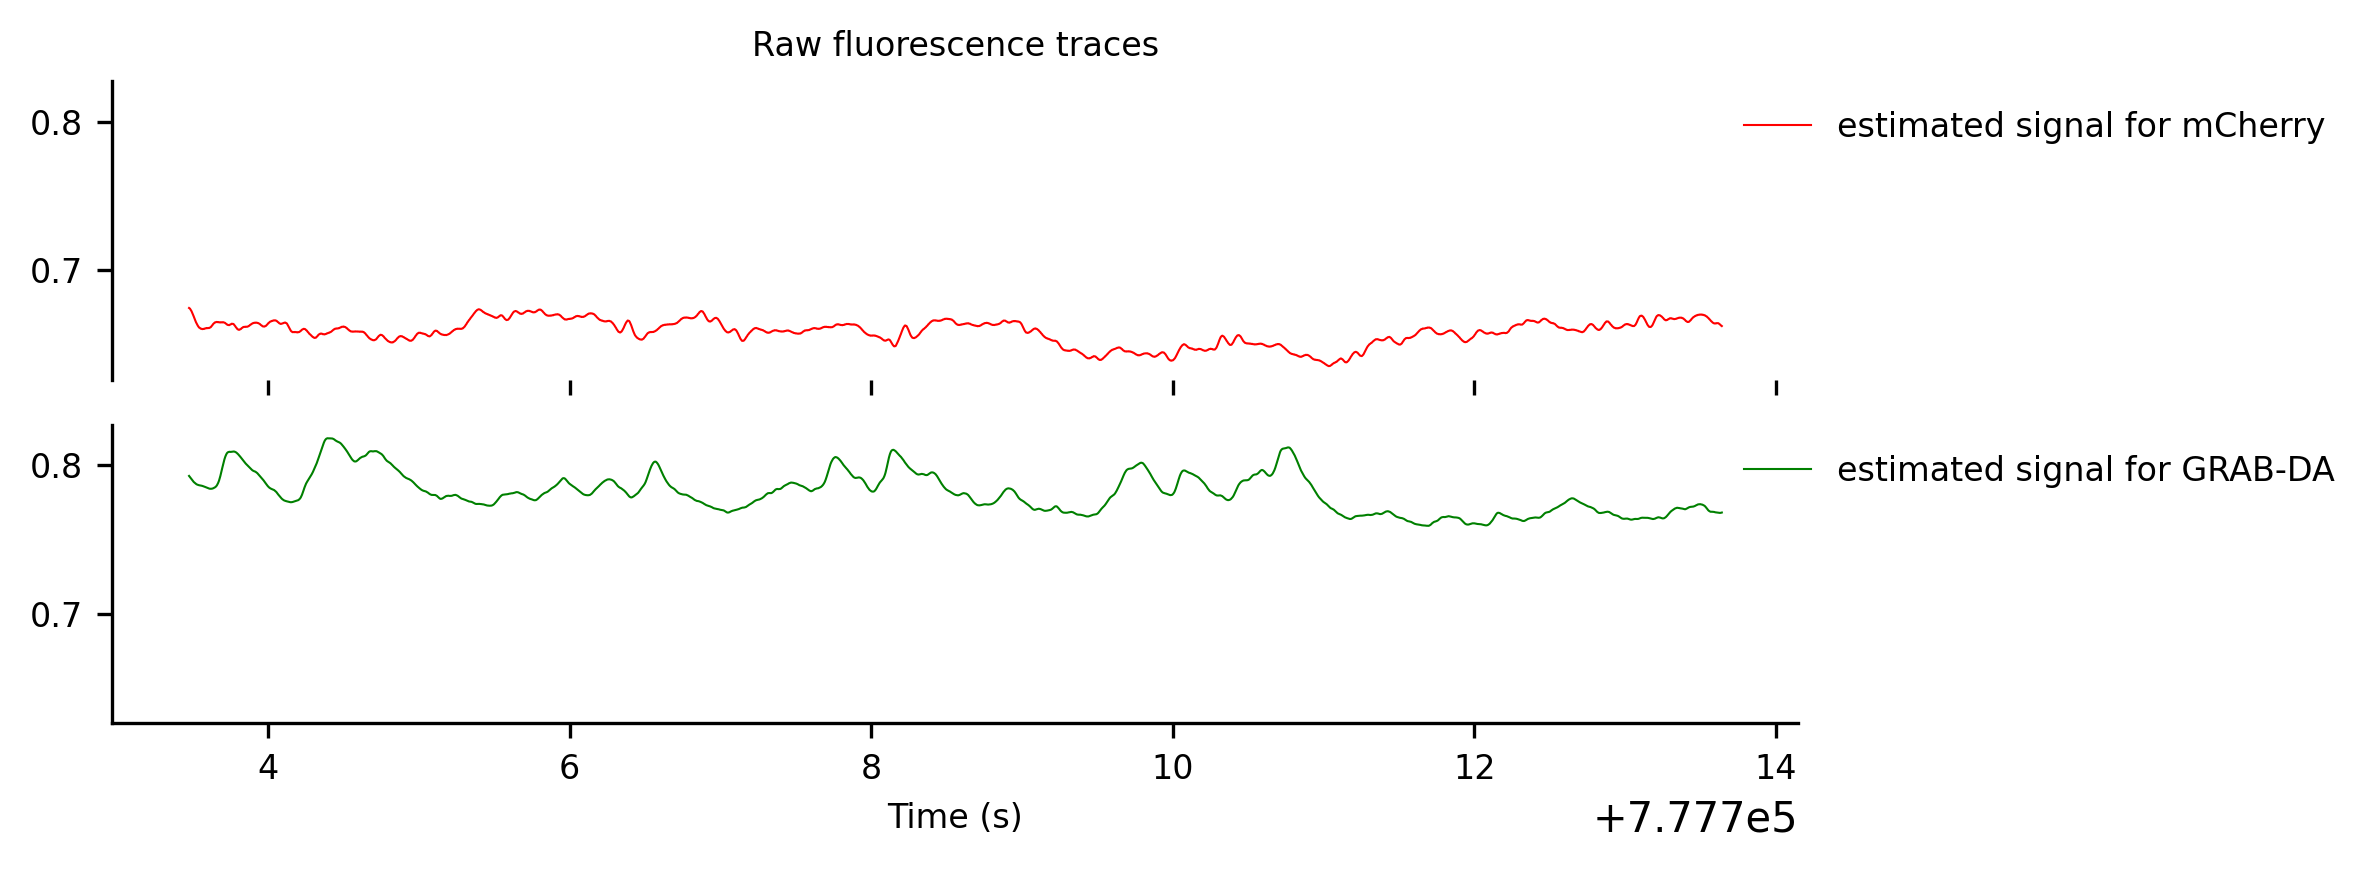

In [11]:
from matplotlib import pyplot as plt

# Prepare data for plotting
data = fiber_photometry_response_series.data[100:5000, :]
timestamps = fiber_photometry_response_series.get_timestamps()[100:5000]

fig, axes = plt.subplots(nrows=data.shape[1], ncols=1, figsize=(8, 3), sharey=True, sharex=True, dpi=300)

legend = ["estimated signal for mCherry", "estimated signal for GRAB-DA"]
color = ["red", "green"]
for i, ax in enumerate(axes):
    ax.plot(timestamps, data[:, i], linewidth=0.5, color=color[i])

    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='x', labelsize=8)

    ax.legend([legend[i]], frameon=False, bbox_to_anchor=(.95, 1), loc='upper left', prop={'size': 8})

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].spines['bottom'].set_visible(False)
axes[0].set_title("Raw fluorescence traces", fontsize=8)
plt.xlabel('Time (s)', fontsize=8)
plt.tick_params(axis='x', labelsize=8)

plt.tight_layout()
plt.show()

## Fiber photometry metadata

The fiber photometry metadata includes the type of indicator(s), optical fiber(s), excitation source(s), photodector(s), dichroic mirror(s), and optical filter(s) that were used to construct a single fluorescence signal.

The metadata is stored in a `FiberPhotometryTable` object using [`ndx-fiber-photometry`](https://github.com/catalystneuro/ndx-fiber-photometry) and is added to `nwbfile.lab_meta_data`. It can be accessed as `nwbfile.lab_meta_data["FiberPhotometry"].fiber_photometry_table`.

In [12]:
nwbfile.lab_meta_data["FiberPhotometry"].fiber_photometry_table[:]

,location,indicator,optical_fiber,excitation_source,photodetector,dichroic_mirror,coordinates
id,,,,,,,
0,NAcc,grab abc.Indicator at 0x4904706240\nFields:\n ...,optical_fiber abc.OpticalFiber at 0x4904706192...,excitation_source_grab_isosbestic abc.Excitati...,photodetector abc.Photodetector at 0x490470950...,dichroic_mirror abc.DichroicMirror at 0x490402...,"[nan, nan, nan]"
1,NAcc,grab abc.Indicator at 0x4904706240\nFields:\n ...,optical_fiber abc.OpticalFiber at 0x4904706192...,excitation_source_grab abc.ExcitationSource at...,photodetector abc.Photodetector at 0x490470950...,dichroic_mirror abc.DichroicMirror at 0x490402...,"[nan, nan, nan]"
2,NAcc,mcherry abc.Indicator at 0x4904705616\nFields:...,optical_fiber abc.OpticalFiber at 0x4904706192...,excitation_source_mcherry abc.ExcitationSource...,photodetector abc.Photodetector at 0x490470950...,dichroic_mirror abc.DichroicMirror at 0x490402...,"[nan, nan, nan]"


The `fiber_photometry_table_region` attribute in the `FiberPhotometryResponseSeries` object references row(s) of this table:

In [14]:
fiber_photometry_table_region = nwbfile.acquisition["estimated_fiber_photometry_response_series"].fiber_photometry_table_region[:]
fiber_photometry_table_region.head()

,location,indicator,optical_fiber,excitation_source,photodetector,dichroic_mirror,coordinates
id,,,,,,,
1,NAcc,grab abc.Indicator at 0x4904706240\nFields:\n ...,optical_fiber abc.OpticalFiber at 0x4904706192...,excitation_source_grab abc.ExcitationSource at...,photodetector abc.Photodetector at 0x490470950...,dichroic_mirror abc.DichroicMirror at 0x490402...,"[nan, nan, nan]"
2,NAcc,mcherry abc.Indicator at 0x4904705616\nFields:...,optical_fiber abc.OpticalFiber at 0x4904706192...,excitation_source_mcherry abc.ExcitationSource...,photodetector abc.Photodetector at 0x490470950...,dichroic_mirror abc.DichroicMirror at 0x490402...,"[nan, nan, nan]"


The metadata on the optical fiber is added to `nwbfile.devices` and can be accessed as `nwbfile.devices["optical_fiber"]` or can be accessed from the referenced optical fiber in the `fiber_photometry_table_region` of the `FiberPhotometryResponseSeries`.

In [17]:
fiber_photometry_table_region["optical_fiber"][1]

optical_fiber abc.OpticalFiber at 0x4904706192
Fields:
  core_diameter_in_um: 400.0
  description: Chronically implantable optic fibers (Thor labs) with 400 µm core, 0.5 NA fiber optics were implanted unilaterally over the injection site (DV -6.7). Doric Lenses hardware and software (Doric Neuroscience Studio) were used to record fluorescence. Two-channel motion artifact correction (TMAC) was used to correct for movement artifacts, with mCherry as the activity-independent channel.
  manufacturer: Thor labs
  numerical_aperture: 0.5

In [19]:
fiber_photometry_table_region["indicator"][1]

grab abc.Indicator at 0x4904706240
Fields:
  description: To measure dopamine activity, AAV9-hsyn-GRAB-DA2h (AddGene #140554) was injected into the NAcc.
  injection_location: NAcc
  label: AAV9-hsyn-GRAB-DA2h
  manufacturer: Addgene

In [20]:
fiber_photometry_table_region["excitation_source"][1]

excitation_source_grab abc.ExcitationSource at 0x4904704752
Fields:
  description: The excitation wavelength for GRAB indicator.
  excitation_wavelength_in_nm: 470.0
  illumination_type: LED
  manufacturer: Doric Lenses

In [21]:
fiber_photometry_table_region["photodetector"][1]

photodetector abc.Photodetector at 0x4904709504
Fields:
  detected_wavelength_in_nm: 470.0
  detector_type: photodiode
  manufacturer: Doric Lenses
  model: TBD

In [22]:
fiber_photometry_table_region["dichroic_mirror"][1]

dichroic_mirror abc.DichroicMirror at 0x4904029360
Fields:
  manufacturer: Doric Lenses

# Access raw behavior data

This section demonstrates how to access the Bpod data in the NWBFile.

## Accessing the task metadata

The task-related general metadata is stored in a `Task` object which can be accessed as `nwbfile.lab_meta_data["task"]`.

The `EventTypesTable` is a column-based table to store the type of events that occur during the task (e.g. port poke from the animal), one type per row.
This table can be accessed as `nwbfile.lab_meta_data["task"].event_types`.


In [3]:
nwbfile.lab_meta_data["task"].event_types[:]

,event_name
id,
0,state_timer
1,left_port_poke
2,center_port_poke
3,right_port_poke


The `ActionTypesTable` is a column-based table to store the type of actions that occur during the task (e.g. sound output from the acquisition system), one type per row.
This table can be accessed as `nwbfile.lab_meta_data["task"].action_types`.

The `ActionTypesTable` is a column-based table to store the type of actions that occur during the task (e.g. sound output from the acquisition system), one type per row.
This table can be accessed as `nwbfile.lab_meta_data["task"].action_types`.

In [5]:
nwbfile.lab_meta_data["task"].action_types[:]

,action_name
id,
0,sound_output


The `StateTypesTable` is a column-based table to store the type of states that occur during the task (e.g. while the animal is waiting for reward), one type per row.
This table can be accessed as `nwbfile.lab_meta_data["task"].state_types`.

In [6]:
nwbfile.lab_meta_data["task"].state_types[:]

,state_name
id,
0,opt_out
1,stop_sound
2,go_cue
3,wait_for_side_poke
4,punish_violation
5,wait_for_poke
6,nose_in_center
7,announce_reward
8,reward


The arguments for the task is stored in a `TaskArgumentsTable` which can be accessed as `nwbfile.lab_meta_data["task"].task_arguments`.


In [7]:
nwbfile.lab_meta_data["task"].task_arguments[:]

,argument_name,argument_description,expression,expression_type,output_type
id,,,,,
0,reward_volume_ul,The volume of reward in microliters.,40,integer,numeric
1,nose_in_center,The time in seconds when the animal is require...,1.09128201436924,double,numeric
2,time_increment_for_nose_in_center,The time increment for nose in center in seconds.,0,double,numeric
3,target_duration_for_nose_in_center,The goal for how long the animal must poke cen...,1,double,numeric
4,training_stage,The stage of the training.,9,integer,numeric
5,reward_delay,"The delay in seconds to receive reward, drawn ...",0.03789609238432629,double,numeric
6,target_reward_delay,The target delay in seconds to receive reward.,1.5,double,numeric
7,time_increment_for_reward_delay,The time increment during monotonic increase o...,0.025,double,numeric
8,violation_time_out,The time-out if nose is center is not satisfie...,1,double,numeric


The `TaskRecording` object stores the data for events, states, and actions that occured during the task. The `TaskRecording` is added as acquisition which can be accessed as `nwbfile.acquisition["task_recording"]`.

The `EventsTable` is a column-based table to store the information about the events (e.g. poke times), one event per row. This table can be accessed as `nwbfile.acquisition["task_recording"].events`.

In [9]:
import pandas as pd

pd.merge(
    nwbfile.acquisition["task_recording"].events[:],
    nwbfile.lab_meta_data["task"].event_types[:],
    left_on="event_type",
    right_on="id",
)

,timestamp,event_type,value,event_name
0,103.3331,2,In,center_port_poke
1,103.4485,2,In,center_port_poke
2,103.4420,2,Out,center_port_poke
3,103.5575,2,Out,center_port_poke
4,104.4420,0,Expired,state_timer
...,...,...,...,...
12596,4785.5592,2,In,center_port_poke
12597,4785.9513,2,In,center_port_poke
12598,4785.9286,2,Out,center_port_poke
12599,4786.1974,2,Out,center_port_poke


The `ActionsTable` is a column-based table to store the information about the actions (e.g. sound onset times), one action per row. This table can be accessed as `nwbfile.acquisition["task_recording"].actions`.

In [ ]:
pd.merge(
    nwbfile.acquisition["task_recording"].actions[:],
    nwbfile.lab_meta_data["task"].action_types[:],
    left_on="action_type",
    right_on="id",
).head()

In [10]:
pd.merge(
    nwbfile.acquisition["task_recording"].actions[:],
    nwbfile.lab_meta_data["task"].action_types[:],
    left_on="action_type",
    right_on="id",
).head()

,timestamp,action_type,value,action_name
0,11.4262,0,On,sound_output
1,11.6163,0,On,sound_output
2,103.3332,0,On,sound_output
3,103.4421,0,On,sound_output
4,103.9423,0,On,sound_output


The `StatesTable` is a column-based table to store the information about the states (e.g. the duration while nose is in center port). This table can be accessed as `nwbfile.acquisition["task_recording"].states`.

In [11]:
pd.merge(
    nwbfile.acquisition["task_recording"].states[:],
    nwbfile.lab_meta_data["task"].state_types[:],
    left_on="state_type",
    right_on="id",
).head()

,start_time,stop_time,state_type,state_name
0,11.4261,103.3331,5,wait_for_poke
1,103.3331,103.4420,6,nose_in_center
2,103.4420,104.4420,4,punish_violation
3,104.5276,144.9311,5,wait_for_poke
4,144.9311,144.9435,6,nose_in_center


### Plot the events, actions, and states

The ``plot_events``, ``plot_actions``, and ``plot_states`` functions can consume both the raw table as well as a subset of the table as a pandas DataFrame created through slicing, e.g., via ``events[:100]`` will plot only the first 100 rows from the events table.

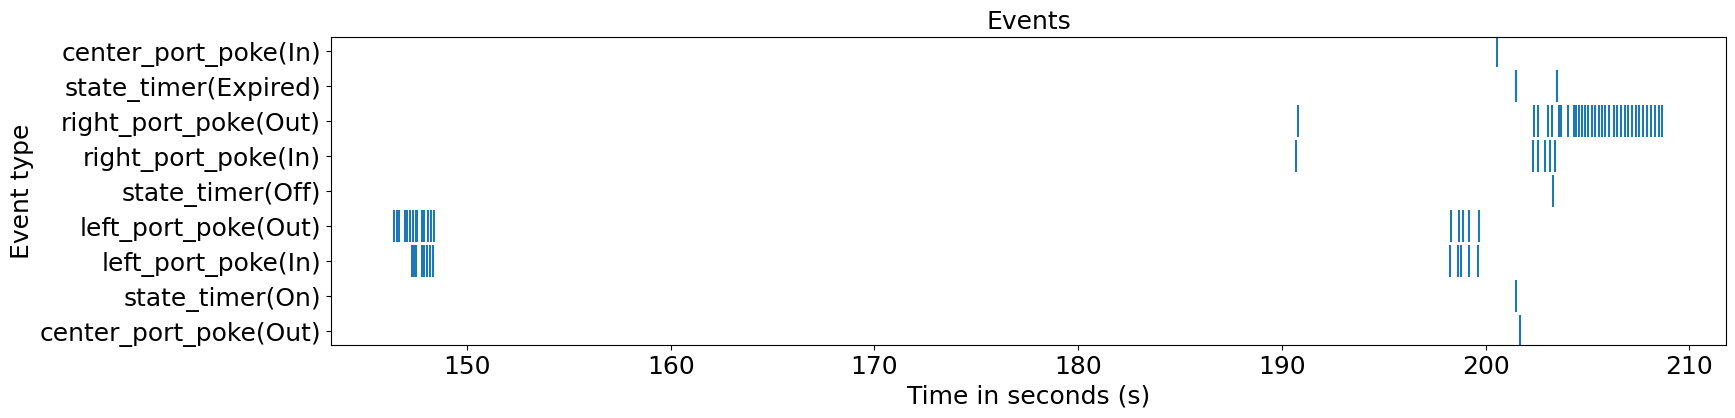

In [12]:
from matplotlib import pyplot as plt
from ndx_structured_behavior.plot import plot_events, plot_actions, plot_states, plot_trials

# Get the events from file
events = nwbfile.get_acquisition("task_recording").events
event_types = nwbfile.get_lab_meta_data("task").event_types

# Plot the data
fig = plot_events(
    events=events[20:100],
    event_types=event_types,
    show_event_values=True,
    figsize=(18,4),
    marker_size=500,
)
plt.title("Events", fontsize=18)
plt.show()

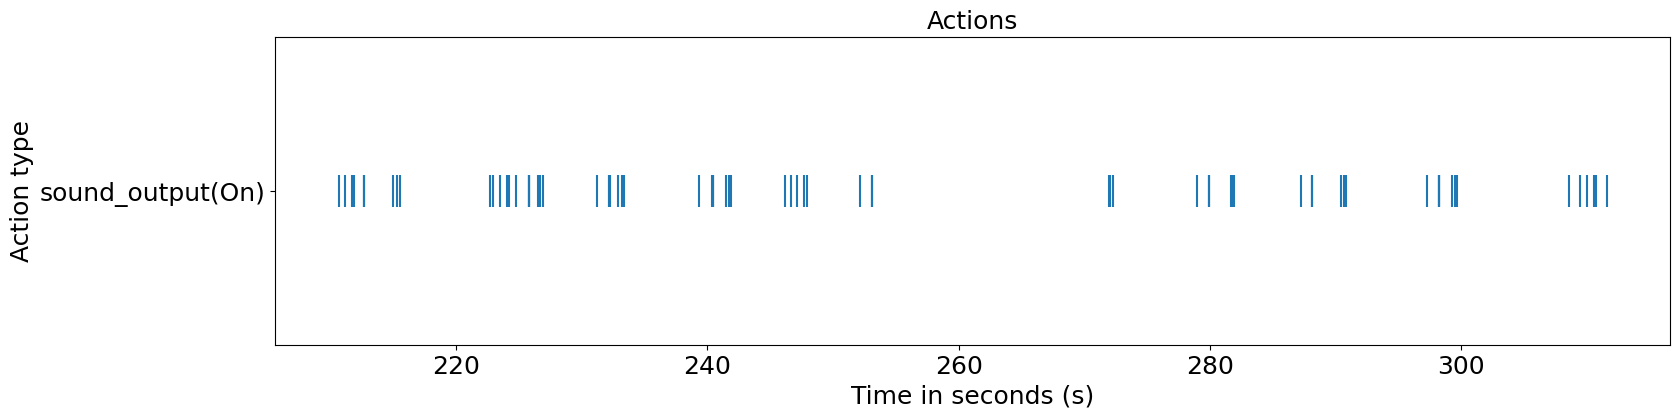

In [13]:
# Get the actions from file
actions = nwbfile.get_acquisition("task_recording").actions
action_types = nwbfile.get_lab_meta_data("task").action_types

# Plot the data
fig = plot_actions(
    actions=actions[20:100],
    action_types=action_types,
    figsize=(18,4),
    marker_size=500,
)
plt.title("Actions", fontsize=18)
plt.show()

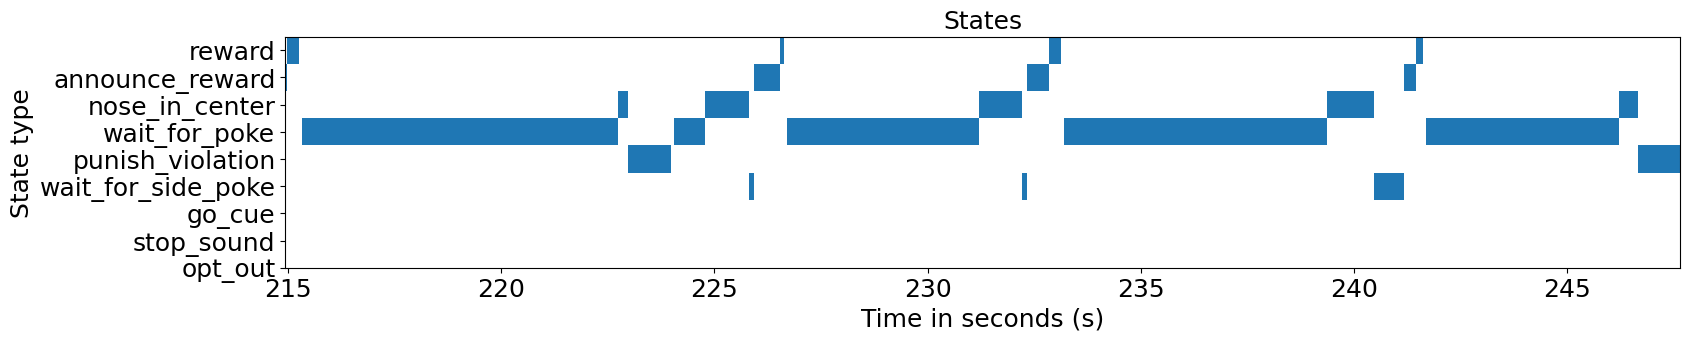

In [15]:
# Get the states from file
states = nwbfile.get_acquisition("task_recording").states
state_types = nwbfile.get_lab_meta_data("task").state_types

# Plot the data
plot_states(states=states[20:50],
            state_types=state_types,
            marker_size=500)
plt.title("States", fontsize=18)
plt.show()

In [16]:
trials = nwbfile.trials

trials[:].head()

,start_time,stop_time,states,events,actions,high_ITI,target_duration_for_nose_in_center,target_reward_delay,is_catch,catch_percentage,...,training_stage,block_type,trials_in_stage,reward_delay,cumulative_reward_volume_ul,center_port_cue,is_warm_up,changed,previous_was_violation,auto_change_catch_probability
id,,,,,,,,,,,,,,,,,,,,,
0,11.4261,104.4420,"[0, 1]","[0, 1, 2, 3]","[0, 1, 2, 3, 4]",0,1,1.5,False,0.25,...,9,Mixed,42622,0.037896,0,False,False,False,False,False
1,104.5276,145.9435,"[3, 4]","[5, 6, 7, 8, 9, 10, 11, 12]","[5, 6, 7, 8, 9]",0,1,1.5,False,0.25,...,9,Mixed,42624,1.852722,0,False,False,False,True,False
2,146.0112,203.4972,"[6, 7, 8, 9, 10, 11]","[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...","[10, 11, 12, 13, 14, 15, 16]",0,1,1.5,False,0.25,...,9,Mixed,42625,1.822595,0,False,False,False,True,False
3,203.5646,211.6551,"[13, 14]","[71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 8...","[17, 18, 19, 20, 21]",0,1,1.5,False,0.25,...,9,Mixed,42626,2.707947,20,False,False,False,False,False
4,211.7232,215.2550,"[16, 17, 18, 19, 20, 21]","[143, 144, 145, 146, 148, 149, 150, 151, 152, ...","[22, 23, 24, 25, 26, 27, 28]",0,1,1.5,False,0.25,...,9,Mixed,42627,2.286669,20,False,False,False,True,False


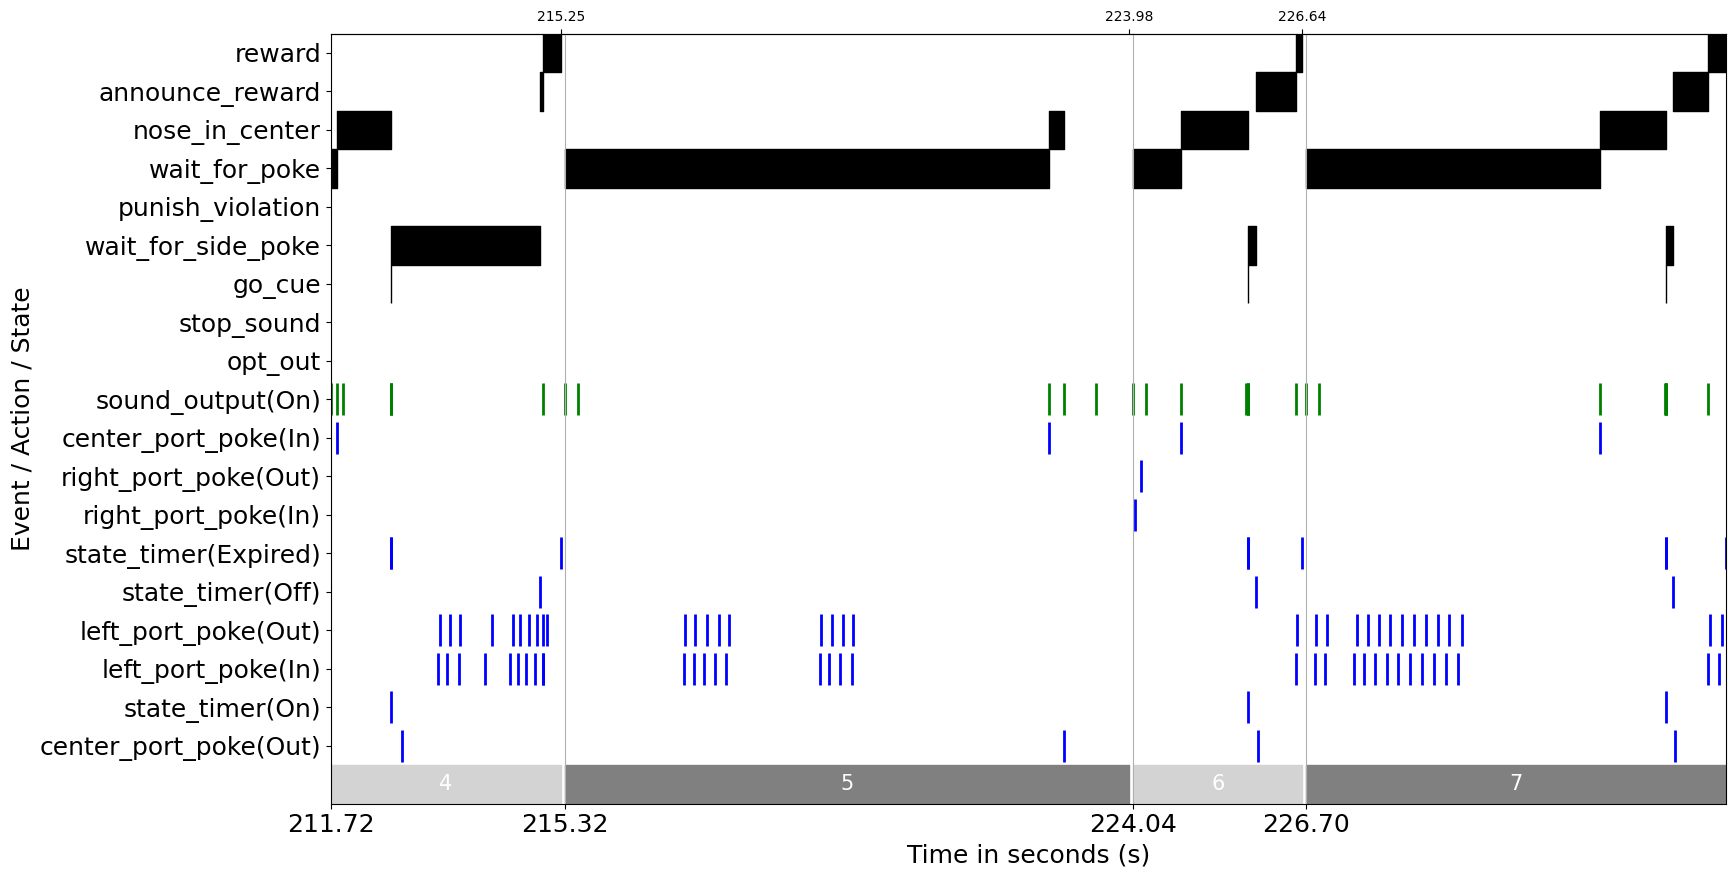

In [19]:
# Plot trial 4 - 7
plot_trials(
    trials=trials[4:8],
    states=states, state_types=state_types,
    actions=actions, action_types=action_types,
    events=events, event_types=event_types,
    figsize=None,
    fontsize=18,
    rectangle_height=1,
    marker_size=500)
plt.show()